In [1]:
import librosa
import numpy as np

# Load the audio file
audio_path = "./vocals_only.wav"
y, sr = librosa.load(audio_path, sr=None)

# Parameters for voice activity detection
frame_length = 2560  # 2048
hop_length = 256  # 512
energy_threshold = 0.01

# Calculate short-time energy using vectorized operations
energy = np.lib.stride_tricks.sliding_window_view(y, frame_length)[::hop_length] ** 2
energy = np.sum(energy, axis=1)

# Normalize energy
energy /= np.max(energy)

# Detect voice activity
voice_activity = energy > energy_threshold

# Find start and end times of voice activity using boolean indexing
indices = np.flatnonzero(np.diff(voice_activity.astype(int)))
timestamps = []

# Pre-calculate hop_length / sr
hop_duration = hop_length / sr

for i in range(0, len(indices), 2):
    start = indices[i] * hop_duration
    end = indices[i + 1] * hop_duration if i + 1 < len(indices) else len(y) / sr
    timestamps.append({"start": start, "end": end})

# Handle case where audio ends with voice activity
if voice_activity[-1]:
    end = len(y) / sr
    timestamps.append({"start": indices[-1] * hop_duration, "end": end})

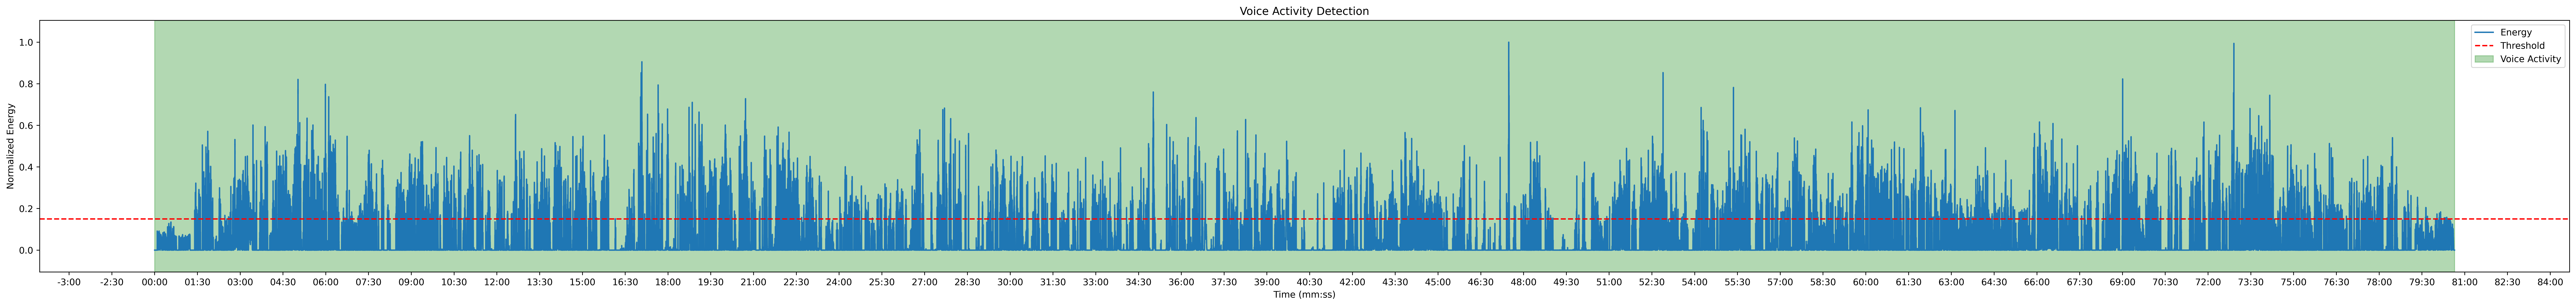

In [2]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator


# Function to format the x-axis ticks as mm:ss
def format_func(value, tick_number):
    minutes = int(value // 60)
    seconds = int(value % 60)
    return f"{minutes:02}:{seconds:02}"


# Plot the energy and detected voice activity
plt.figure(figsize=(50, 5), dpi=500)
plt.plot(np.arange(len(energy)) * hop_duration, energy, label="Energy")
plt.axhline(y=energy_threshold, color="r", linestyle="--", label="Threshold")
plt.fill_between(
    np.arange(len(energy)) * hop_duration,
    0,
    1,
    color="green",
    alpha=0.3,
    transform=plt.gca().get_xaxis_transform(),
    label="Voice Activity",
)

# Set x-axis to display time in seconds (mm:ss)
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))

# Set the frequency of the ticks to be less frequent
plt.gca().xaxis.set_major_locator(
    MultipleLocator(90)
)  # Adjust the interval to 30 seconds

plt.xlabel("Time (mm:ss)")
plt.ylabel("Normalized Energy")
plt.title("Voice Activity Detection")
plt.legend()
plt.show()

In [3]:
def format_timestamps(timestamp: dict):
    return f"{int(timestamp['start'] / 60):02d}:{int(timestamp['start'] % 60):02d} - {int(timestamp['end'] / 60):02d}:{int(timestamp['end'] % 60):02d}"


# merges contiguous timestamps. E.g., 01:11-01:15 and 01:16-01:21 become 01:11-01:21
def merge_contiguous_timestamps(timestamps):
    merged_timestamps = []
    current_start = int(timestamps[0]["start"])
    current_end = int(timestamps[0]["end"])

    for timestamp in timestamps[1:]:
        if int(timestamp["start"]) in [current_end, current_end + 1]:
            current_end = int(timestamp["end"])
        else:
            merged_timestamps.append({"start": current_start, "end": current_end})
            current_start = int(timestamp["start"])
            current_end = int(timestamp["end"])

    merged_timestamps.append({"start": current_start, "end": current_end})

    return merged_timestamps


new_timestamps = merge_contiguous_timestamps(timestamps)

with open("speech_timestamps_FOR_PLOT.txt", "w") as file:

    for timestamp in new_timestamps:
        file.write(f"{format_timestamps(timestamp)}\n")